# Using Machine Learning

## INITIALISATION


In [137]:
import yfinance as yf
import pandas as pd
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator
from ta.trend import MACD
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
import os
import warnings
warnings.filterwarnings("ignore")

In [138]:
symbols = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]

In [139]:
for symbol in symbols:   
    stock = yf.Ticker(symbol)
    info = stock.info
    print(f"Symbol: {symbol}")
    print(f"Name: {info.get('shortName', 'N/A')}")
    print(f"Market: {info.get('market', 'N/A')}")
    print(f"Sector: {info.get('sector', 'N/A')}")
    print("-" * 30)

Symbol: RELIANCE.NS
Name: RELIANCE INDUSTRIES LTD
Market: in_market
Sector: Energy
------------------------------
Symbol: HDFCBANK.NS
Name: HDFC BANK LTD
Market: in_market
Sector: Financial Services
------------------------------
Symbol: INFY.NS
Name: INFOSYS LIMITED
Market: in_market
Sector: Technology
------------------------------


## DATA VISUALISATION


Historical Data for HDFCBANK.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  974.173 |  975.123 |  942.886 |  951.432 | 1.58918e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  957.129 | 1007.5   |  952.381 |  989.081 | 3.01531e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  995.063 | 1002.52  |  968.523 |  975.692 | 1.66107e+07 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  984.665 | 1001.76  |  974.458 |  988.179 | 1.68234e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  982.624 |  994.351 |  969.093 |  991.17  | 1.24184e+07 |           0 |           

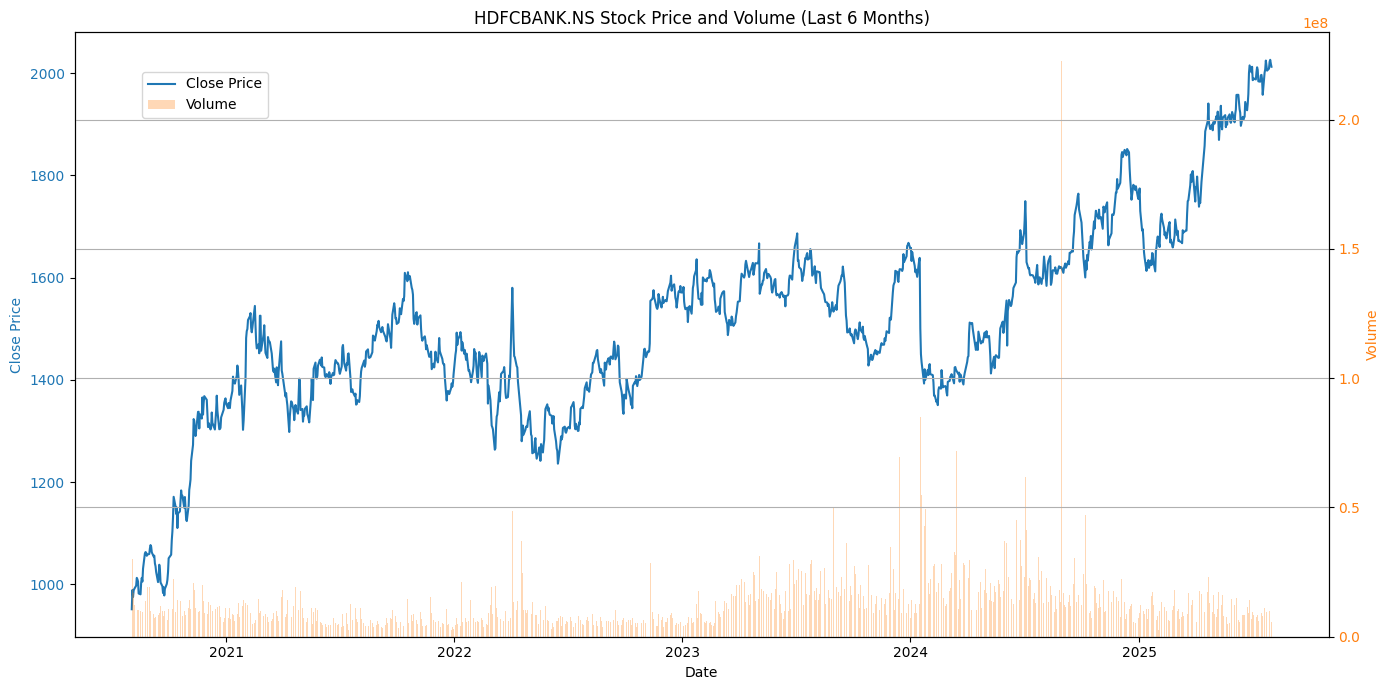

In [140]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'HDFCBANK.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for RELIANCE.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  933.838 |  936.433 |  911.896 |  914.582 | 4.67154e+07 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  919.862 |  986.51  |  910.598 |  979.044 | 9.20411e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  987.42  |  999.712 |  964.34  |  968.05  | 7.455e+07   |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  981.958 |  986.829 |  959.56  |  971.532 | 4.9323e+07  |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  969.575 |  982.322 |  965.205 |  977.155 | 3.29844e+07 |           0 |           

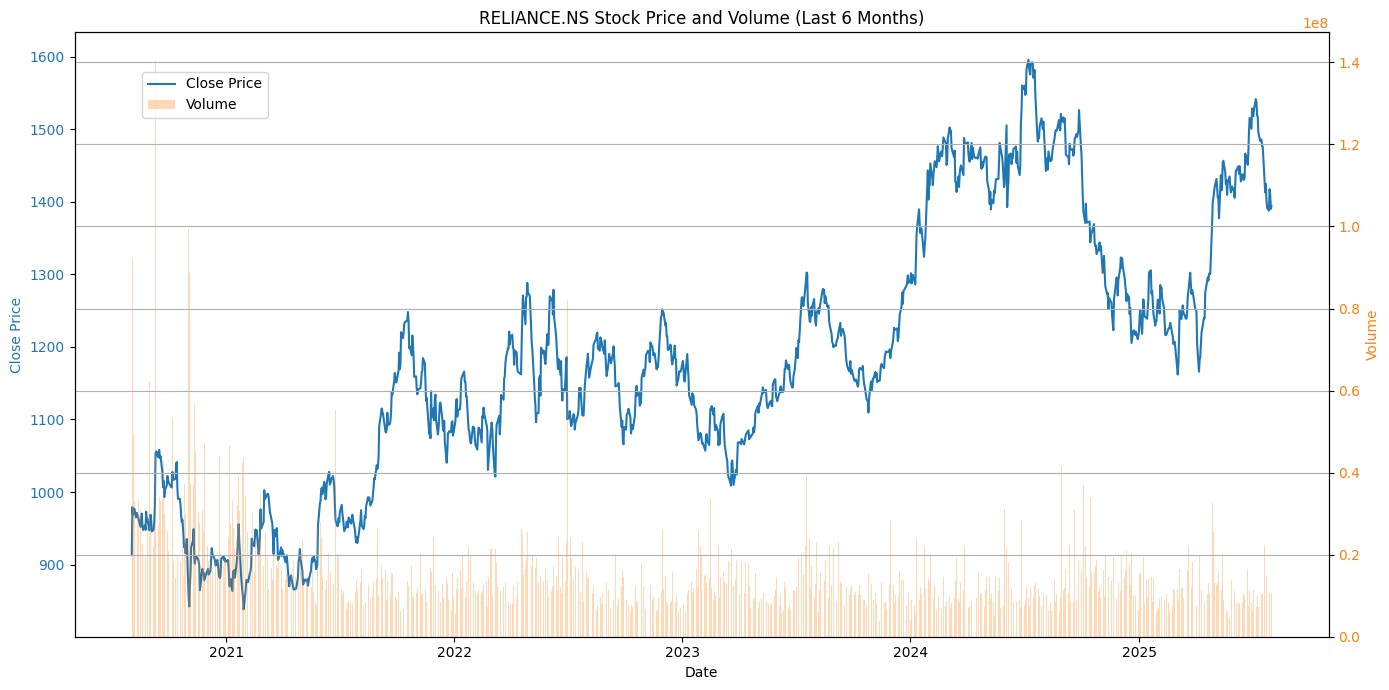

In [141]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'RELIANCE.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

Historical Data for INFY.NS for the last 6 months:
+---------------------------+----------+----------+----------+----------+-------------+-------------+----------------+
| Date                      |     Open |     High |      Low |    Close |      Volume |   Dividends |   Stock Splits |
|---------------------------+----------+----------+----------+----------+-------------+-------------+----------------|
| 2020-08-03 00:00:00+05:30 |  853.778 |  858.581 |  842.617 |  851.021 | 8.47979e+06 |           0 |              0 |
| 2020-08-04 00:00:00+05:30 |  854.179 |  863.294 |  836.48  |  844.751 | 1.11332e+07 |           0 |              0 |
| 2020-08-05 00:00:00+05:30 |  846.664 |  854.623 |  834.479 |  840.171 | 9.61418e+06 |           0 |              0 |
| 2020-08-06 00:00:00+05:30 |  847.997 |  866.585 |  838.215 |  863.428 | 1.09765e+07 |           0 |              0 |
| 2020-08-07 00:00:00+05:30 |  862.183 |  862.183 |  843.995 |  845.685 | 8.01095e+06 |           0 |              0

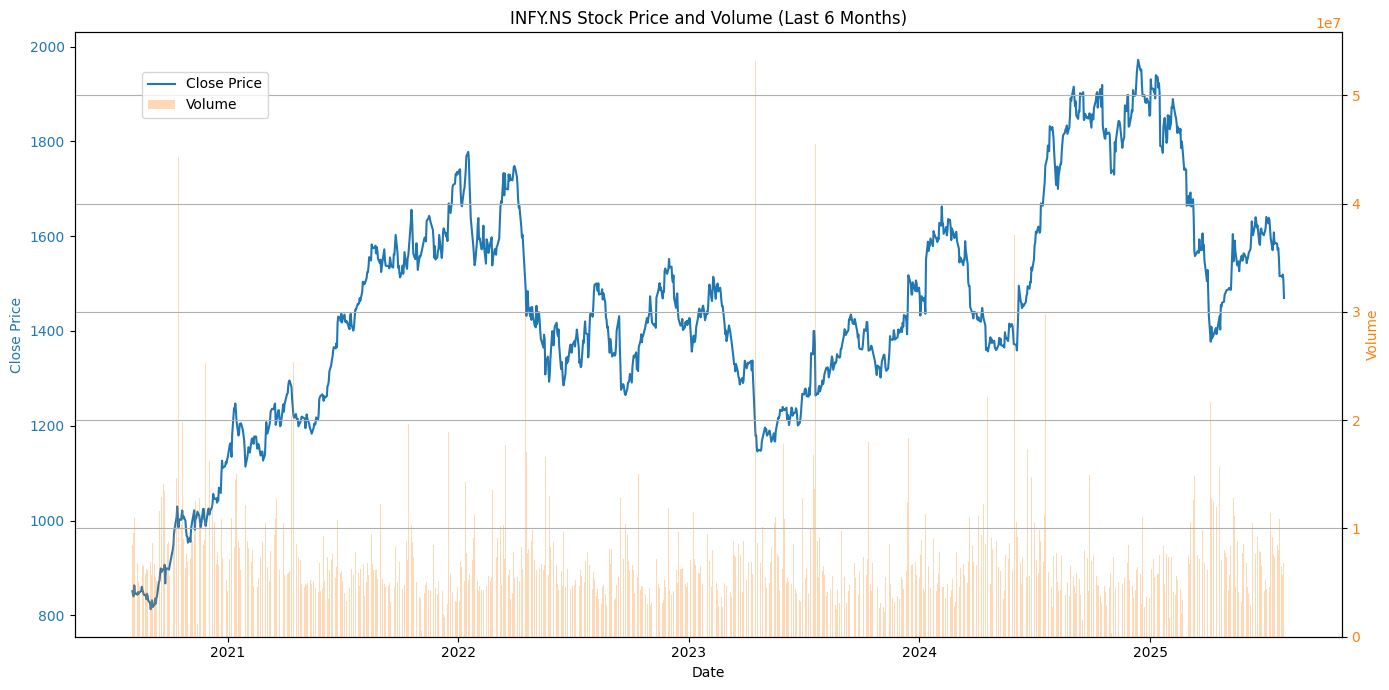

In [142]:
#we will fetch data for the last 6 months for each stock and plot the close price and volume
symbol = 'INFY.NS'
period = '5y'  

stock = yf.Ticker(symbol)
data = stock.history(period=period)

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print(f"Historical Data for {symbol} for the last 6 months:")
formatted_data = pd.concat([data.head(), data.tail()])
print(tabulate(formatted_data, headers='keys', tablefmt='psql'))


# Plotting the data
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.plot(data.index, data['Close'], color='tab:blue', label='Close Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Volume', color='tab:orange')
ax2.bar(data.index, data['Volume'], color='tab:orange', alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title(f'{symbol} Stock Price and Volume (Last 6 Months)')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.grid(True)
plt.show()

## PREPROCESSING THE DATA

In [143]:
from ta.momentum import RSIIndicator
from ta.trend import MACD
import pandas as pd

def preprocess_stock(df):
    df = df.copy()

    # --- Technical Indicators ---
    df["RSI"] = RSIIndicator(df["Close"], window=14).rsi()
    df["MACD"] = MACD(df["Close"]).macd()
    df["MACD_Signal"] = MACD(df["Close"]).macd_signal()
    df["SMA_20"] = df["Close"].rolling(window=20).mean()
    df["SMA_100"] = df["Close"].rolling(window=100).mean()
    df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
    df["Volatility"] = df["Close"].rolling(window=10).std()
    df["Volume"] = df["Volume"]

    # --- Strategy Logic ---
    df["Buy_Signal"] = (
        (df["RSI"] < 30) &
        (df["SMA_20"] > df["SMA_100"]) &
        (df["SMA_20"].shift(1) <= df["SMA_100"].shift(1))
    ).astype(int)

    # --- Target for ML ---
    df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)

    return df.dropna()

In [144]:
symbol_infy = 'INFY.NS'
print(f"Preprocessed data for {symbol_infy}")
data_infy = yf.Ticker(symbol_infy).history(period='5y')
processed_infy = preprocess_stock(data_infy)
processed_infy.head()

Preprocessed data for INFY.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_100,EMA_20,Volatility,Buy_Signal,Target
Date,,,,,,,,,,,,,,,,
2020-12-22 00:00:00+05:30,1062.507339,1100.126549,1057.203769,1097.115234,10901851,0.0,0.0,68.318197,19.274059,15.825539,1035.693002,940.879825,1040.505697,17.298661,0,1
2020-12-23 00:00:00+05:30,1112.846049,1131.588225,1106.149241,1126.374634,15878346,0.0,0.0,72.788058,23.753451,17.411122,1040.771823,943.633358,1048.683691,28.439603,0,0
2020-12-24 00:00:00+05:30,1123.543093,1123.543093,1102.059209,1111.093262,7313885,0.0,0.0,67.436722,25.773225,19.083542,1046.183240,946.296777,1054.627459,31.879776,0,1
2020-12-28 00:00:00+05:30,1113.250510,1121.835109,1111.048233,1114.913574,4607051,0.0,0.0,68.068754,27.366712,20.740176,1051.895789,949.044199,1060.368994,33.879778,0,1
2020-12-29 00:00:00+05:30,1110.149278,1127.632961,1110.149278,1123.902588,6878105,0.0,0.0,69.565589,29.020371,22.396215,1058.651068,951.648948,1066.419813,35.441807,0,0


In [145]:
symbol_reliance = 'RELIANCE.NS'
print(f"Preprocessed data for {symbol_reliance}")
data_reliance = yf.Ticker(symbol_reliance).history(period='2y')
processed_reliance = preprocess_stock(data_reliance)
processed_reliance.head()

Preprocessed data for RELIANCE.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_100,EMA_20,Volatility,Buy_Signal,Target
Date,,,,,,,,,,,,,,,,
2023-12-27 00:00:00+05:30,1286.633203,1295.552881,1282.198303,1289.050049,9204156,0.0,0.0,74.912282,26.623760,21.875170,1235.311133,1201.142518,1241.429312,25.434374,0,1
2023-12-28 00:00:00+05:30,1290.520045,1301.582475,1289.050059,1298.368408,12302636,0.0,0.0,76.754957,27.834480,23.067032,1240.415063,1201.646790,1246.852083,21.811820,0,0
2023-12-29 00:00:00+05:30,1301.133996,1302.579043,1285.287754,1288.103149,10864584,0.0,0.0,70.602835,27.646967,23.983019,1245.585016,1202.181732,1250.780756,17.023883,0,1
2024-01-01 00:00:00+05:30,1285.910692,1299.016237,1282.223134,1290.744263,4030540,0.0,0.0,71.241519,27.395677,24.665550,1250.467194,1202.794977,1254.586805,13.558342,0,1
2024-01-02 00:00:00+05:30,1288.128164,1303.077427,1282.148458,1301.432983,7448800,0.0,0.0,73.729110,27.739257,25.280292,1255.238501,1203.348019,1259.048345,12.374310,0,0


In [146]:
symbol_hdfc = 'HDFCBANK.NS'
print(f"Preprocessed data for {symbol_hdfc}")
data_hdfc = yf.Ticker(symbol_hdfc).history(period='5y')
processed_hdfc = preprocess_stock(data_hdfc)
processed_hdfc.head()

Preprocessed data for HDFCBANK.NS


,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI,MACD,MACD_Signal,SMA_20,SMA_100,EMA_20,Volatility,Buy_Signal,Target
Date,,,,,,,,,,,,,,,,
2020-12-22 00:00:00+05:30,1314.913070,1314.913070,1277.121618,1303.803467,11425779,0.0,0.0,49.473672,14.663817,22.065693,1329.773071,1147.289985,1317.088693,21.467420,0,1
2020-12-23 00:00:00+05:30,1298.485895,1311.257063,1292.361456,1306.224609,7733697,0.0,0.0,49.959331,12.253260,20.103207,1326.803406,1150.837914,1316.054019,21.743545,0,1
2020-12-24 00:00:00+05:30,1319.280686,1333.143839,1307.506458,1326.592041,7476094,0.0,0.0,53.967779,11.849761,18.452517,1326.532776,1154.213027,1317.057640,21.700868,0,1
2020-12-28 00:00:00+05:30,1334.093554,1349.286079,1333.144021,1341.547363,5849597,0.0,0.0,56.709896,12.591606,17.280335,1325.877606,1157.871577,1319.389994,22.176003,0,1
2020-12-29 00:00:00+05:30,1349.333440,1362.341992,1348.336385,1355.172974,7247673,0.0,0.0,59.100392,14.116273,16.647523,1325.229553,1161.541520,1322.797897,22.437444,0,1


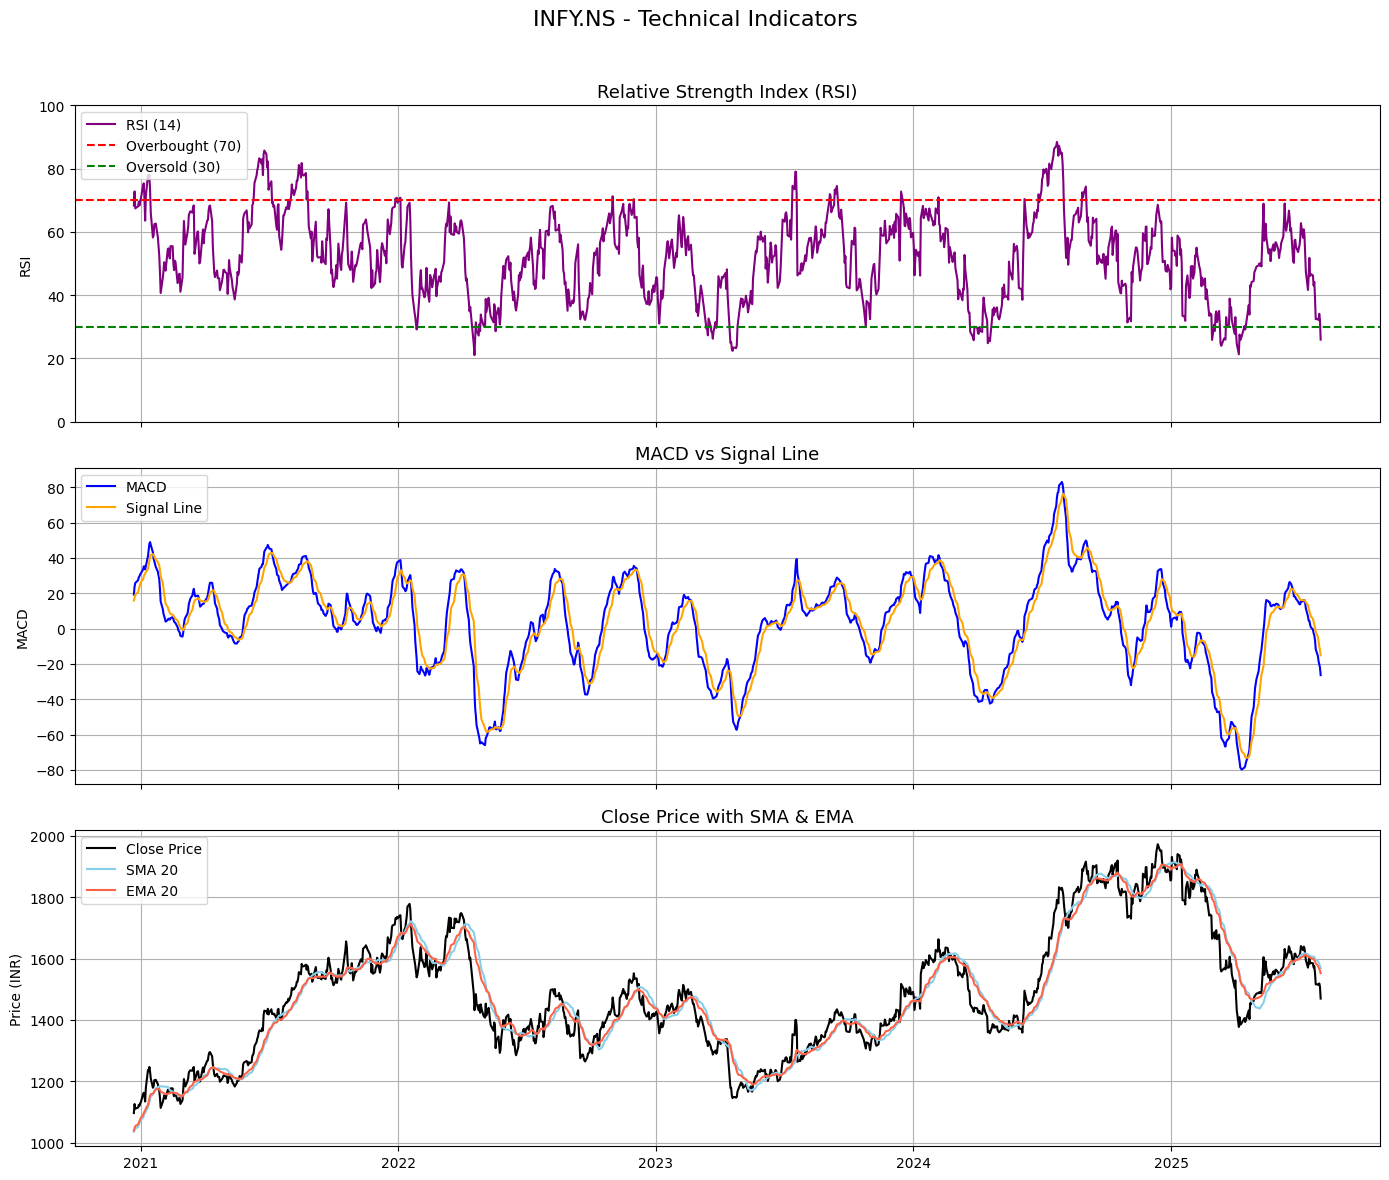

In [147]:
symbol = 'INFY.NS' 
data = processed_infy 

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

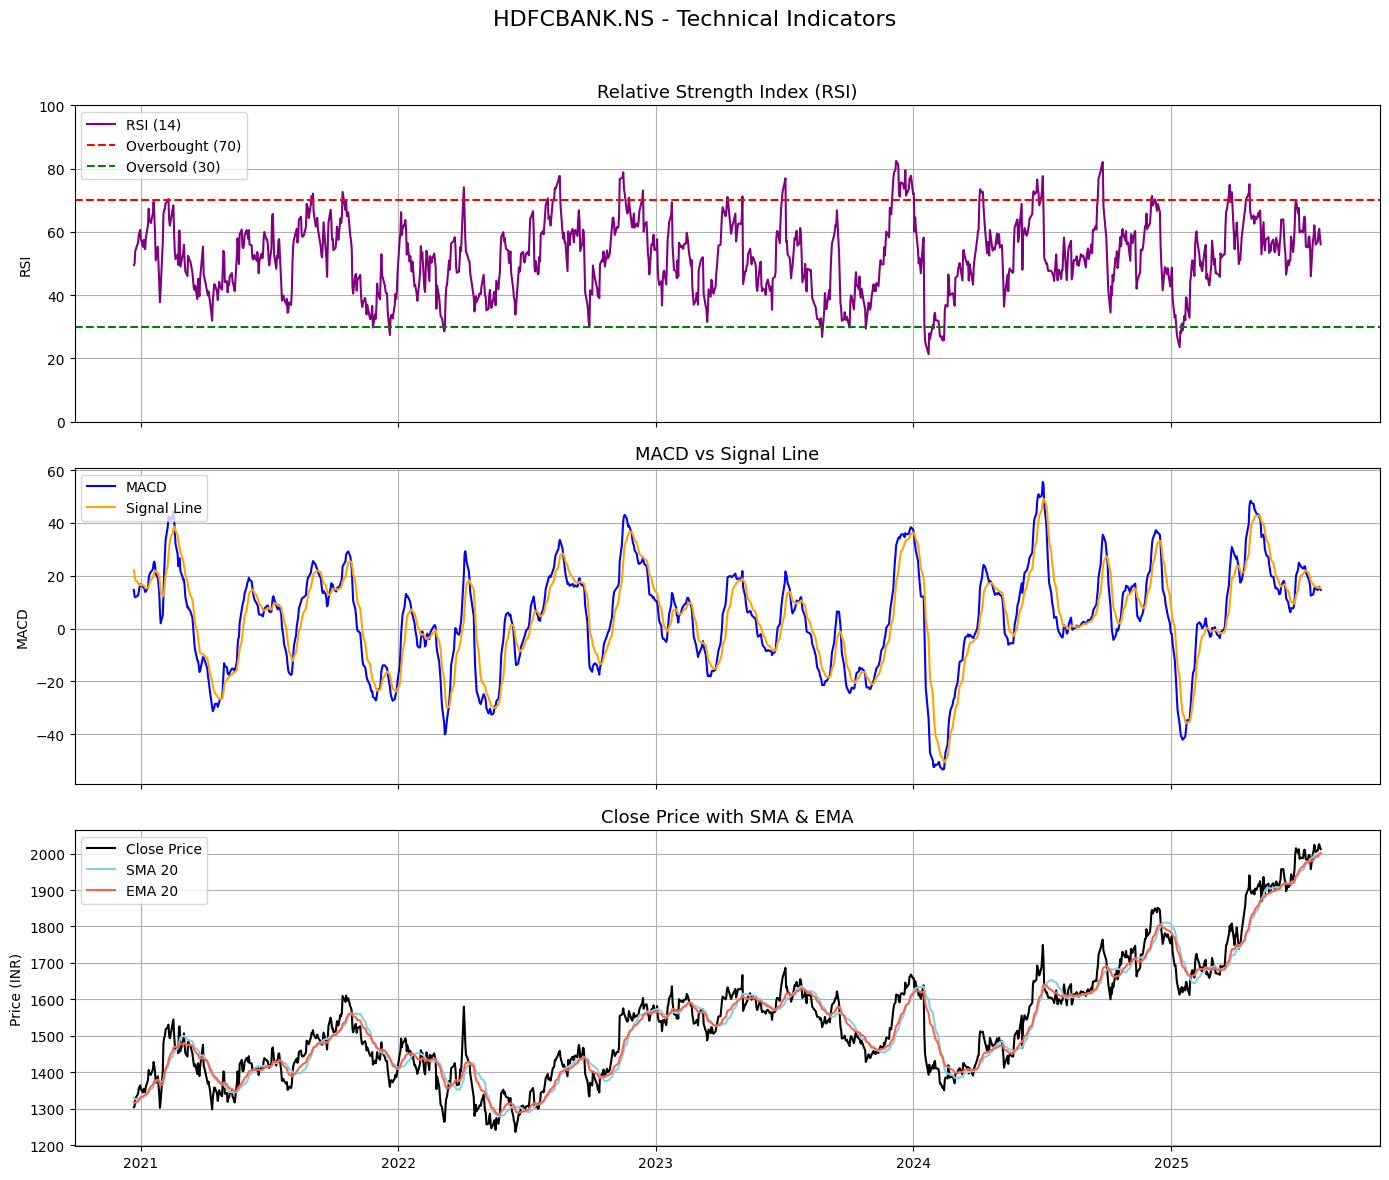

In [148]:
symbol = 'HDFCBANK.NS'
data = processed_hdfc  # Make sure this is defined from preprocessing

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

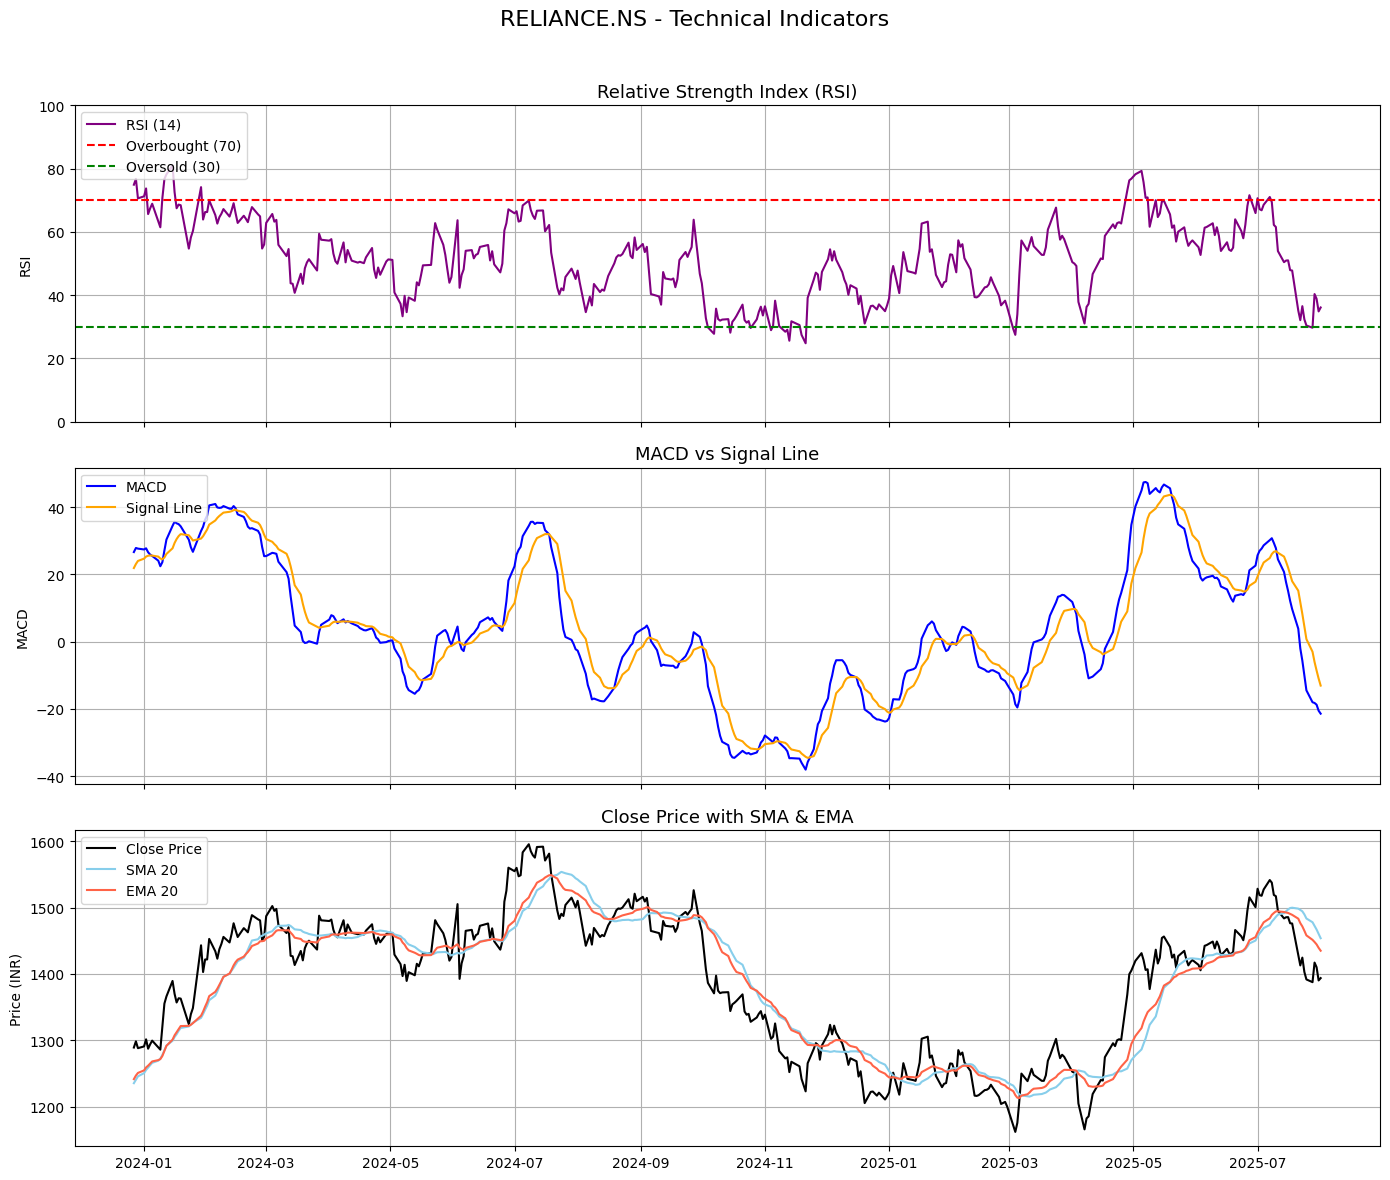

In [149]:
symbol = 'RELIANCE.NS'
data = processed_reliance  # Again, this should be defined already

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle(f'{symbol} - Technical Indicators', fontsize=16)

# RSI
axes[0].plot(data.index, data['RSI'], label='RSI (14)', color='purple')
axes[0].axhline(70, color='red', linestyle='--', label='Overbought (70)')
axes[0].axhline(30, color='green', linestyle='--', label='Oversold (30)')
axes[0].set_ylim(0, 100)
axes[0].set_ylabel('RSI')
axes[0].set_title('Relative Strength Index (RSI)', fontsize=13)
axes[0].legend(loc='upper left')
axes[0].grid(True)

# MACD
axes[1].plot(data.index, data['MACD'], label='MACD', color='blue')
axes[1].plot(data.index, data['MACD_Signal'], label='Signal Line', color='orange')
axes[1].set_ylabel('MACD')
axes[1].set_title('MACD vs Signal Line', fontsize=13)
axes[1].legend(loc='upper left')
axes[1].grid(True)

# Close + SMA + EMA
axes[2].plot(data.index, data['Close'], label='Close Price', color='black')
axes[2].plot(data.index, data['SMA_20'], label='SMA 20', color='skyblue')
axes[2].plot(data.index, data['EMA_20'], label='EMA 20', color='tomato')
axes[2].set_ylabel('Price (INR)')
axes[2].set_title('Close Price with SMA & EMA', fontsize=13)
axes[2].legend(loc='upper left')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## MODEL TRAINING AND BACKTESTING

### INFY.NS

In [150]:
# Prepare Data ===
symbol = 'INFY.NS'
data = yf.Ticker(symbol).history(period='5y')
processed_infy = preprocess_stock(data)
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
X = processed_infy[features]
y = processed_infy["Target"]

# Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=0,
    n_jobs=-1
)
grid.fit(X, y)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19

Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100}



✅ Accuracy: 0.903
✅ Precision: 0.891


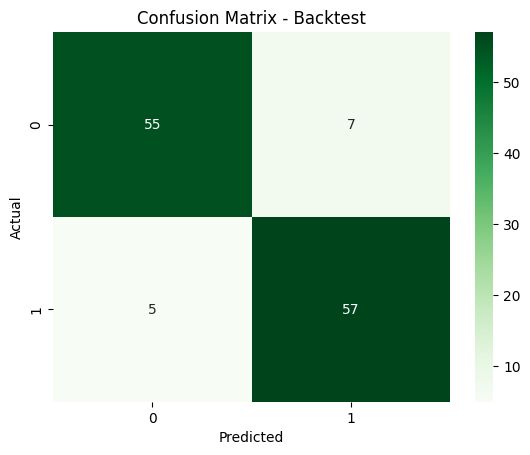

              precision    recall  f1-score   support

           0       0.92      0.89      0.90        62
           1       0.89      0.92      0.90        62

    accuracy                           0.90       124
   macro avg       0.90      0.90      0.90       124
weighted avg       0.90      0.90      0.90       124



In [151]:
# Backtest (Last 6 Months Only) ===
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]
y_pred = best_model.predict(X_backtest)

# Classification Report + Confusion Matrix ===
print("\n✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_backtest, y_pred))

In [152]:
# Simulate Trading Based on ML Predictions ===
backtest_df = processed_infy.loc[X_backtest.index].copy()
backtest_df["ML_Prediction"] = y_pred
backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

backtest_df["Trade_Return"] = (backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / backtest_df["Buy_Price"]
backtest_df = backtest_df.dropna(subset=["Trade_Return"])

# Trade Metrics ===
total_trades = len(backtest_df)
profitable_trades = (backtest_df["Trade_Return"] > 0).sum()
avg_return = backtest_df["Trade_Return"].mean()
hit_ratio = profitable_trades / total_trades
cumulative_return = (1 + backtest_df["Trade_Return"]).prod() - 1

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"🎯 Hit Ratio: {round(hit_ratio, 2)}")
print(f"💸 Avg Trade Return: {round(avg_return*100, 2)}%")
print(f"📈 Cumulative Return: {round(cumulative_return*100, 2)}%")


📊 Total Trades: 64
✅ Profitable Trades: 57
🎯 Hit Ratio: 0.89
💸 Avg Trade Return: 0.77%
📈 Cumulative Return: 62.48%


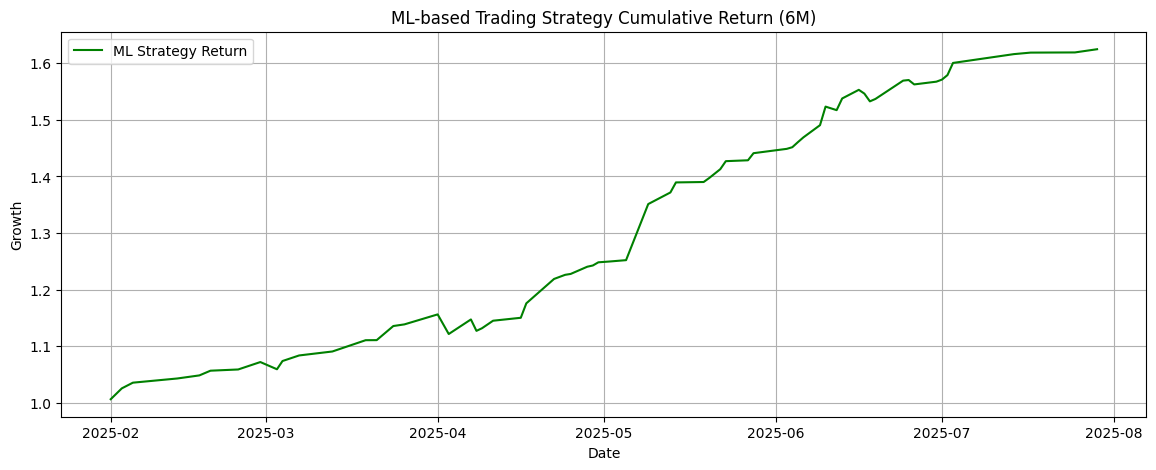

In [153]:
# === Step 7: Visualize Cumulative Return ===
plt.figure(figsize=(14, 5))
plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(), label="ML Strategy Return", color='green')
plt.title("ML-based Trading Strategy Cumulative Return (6M)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.legend()
plt.show()

In [154]:
# === Step 8: Profit vs Loss Summary ===
df_recent = processed_infy[last_6mo].copy()
df_recent["Predicted"] = best_model.predict(df_recent[features])
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

profitable_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 1)]
losing_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 0)]

total_trades = len(profitable_trades) + len(losing_trades)
win_ratio = len(profitable_trades) / total_trades if total_trades > 0 else 0
avg_profit = profitable_trades["Trade_Return"].mean()
avg_loss = losing_trades["Trade_Return"].mean()

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {len(profitable_trades)}")
print(f"❌ Losing Trades: {len(losing_trades)}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")


📊 Total Trades: 64
✅ Profitable Trades: 57
❌ Losing Trades: 7
🎯 Win Ratio: 0.89
📈 Avg Profit: 1.01%
📉 Avg Loss: -1.17%


### RELIANCE.NS

In [155]:
# Prepare Data ===
symbol = 'RELIANCE.NS'
data = yf.Ticker(symbol).history(period='5y')
processed_reliance = preprocess_stock(data)
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
X = processed_reliance[features]
y = processed_reliance["Target"]

# Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=0,
    n_jobs=-1
)
grid.fit(X, y)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}



✅ Accuracy: 0.694
✅ Precision: 0.69


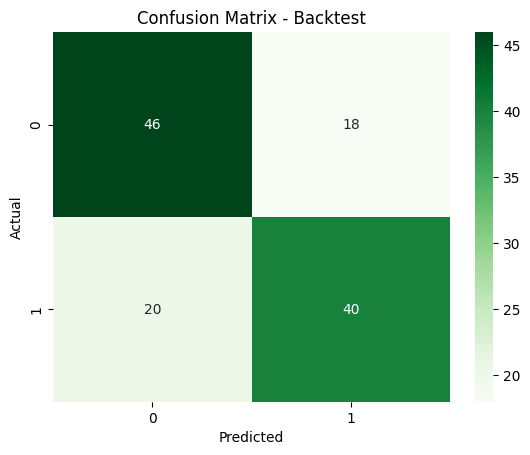

              precision    recall  f1-score   support

           0       0.70      0.72      0.71        64
           1       0.69      0.67      0.68        60

    accuracy                           0.69       124
   macro avg       0.69      0.69      0.69       124
weighted avg       0.69      0.69      0.69       124



In [156]:
# Backtest (Last 6 Months Only) ===
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]
y_pred = best_model.predict(X_backtest)

# Classification Report + Confusion Matrix ===
print("\n✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_backtest, y_pred))

In [157]:
# Simulate Trading Based on ML Predictions ===
backtest_df = processed_infy.loc[X_backtest.index].copy()
backtest_df["ML_Prediction"] = y_pred
backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

backtest_df["Trade_Return"] = (backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / backtest_df["Buy_Price"]
backtest_df = backtest_df.dropna(subset=["Trade_Return"])

# Trade Metrics ===
total_trades = len(backtest_df)
profitable_trades = (backtest_df["Trade_Return"] > 0).sum()
avg_return = backtest_df["Trade_Return"].mean()
hit_ratio = profitable_trades / total_trades
cumulative_return = (1 + backtest_df["Trade_Return"]).prod() - 1

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"🎯 Hit Ratio: {round(hit_ratio, 2)}")
print(f"💸 Avg Trade Return: {round(avg_return*100, 2)}%")
print(f"📈 Cumulative Return: {round(cumulative_return*100, 2)}%")


📊 Total Trades: 57
✅ Profitable Trades: 35
🎯 Hit Ratio: 0.61
💸 Avg Trade Return: 0.1%
📈 Cumulative Return: 5.02%


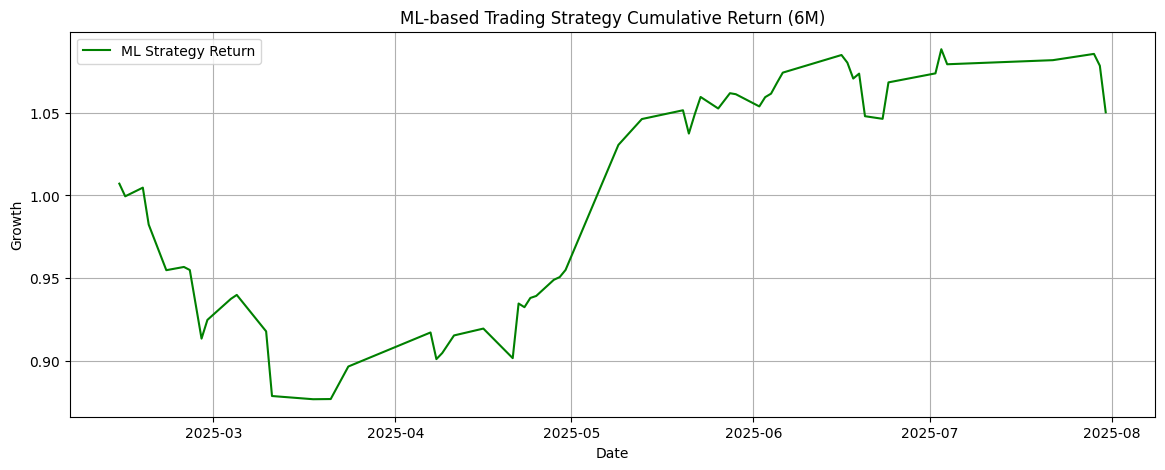

In [158]:
# === Step 7: Visualize Cumulative Return ===
plt.figure(figsize=(14, 5))
plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(), label="ML Strategy Return", color='green')
plt.title("ML-based Trading Strategy Cumulative Return (6M)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.legend()
plt.show()

In [159]:
# === Step 8: Profit vs Loss Summary ===
df_recent = processed_infy[last_6mo].copy()
df_recent["Predicted"] = best_model.predict(df_recent[features])
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

profitable_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 1)]
losing_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 0)]

total_trades = len(profitable_trades) + len(losing_trades)
win_ratio = len(profitable_trades) / total_trades if total_trades > 0 else 0
avg_profit = profitable_trades["Trade_Return"].mean()
avg_loss = losing_trades["Trade_Return"].mean()

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {len(profitable_trades)}")
print(f"❌ Losing Trades: {len(losing_trades)}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")


📊 Total Trades: 59
✅ Profitable Trades: 30
❌ Losing Trades: 29
🎯 Win Ratio: 0.51
📈 Avg Profit: 1.15%
📉 Avg Loss: -1.64%


### HDFCBANK.NS

In [160]:
# === Step 1: Prepare Data ===
symbol = 'HDFCBANK.NS'
data = yf.Ticker(symbol).history(period='5y')
processed_hdfcbank = preprocess_stock(data)
features = ["RSI", "MACD", "MACD_Signal", "SMA_20", "EMA_20", "Volatility"]
X = processed_hdfcbank[features]
y = processed_hdfcbank["Target"]

# === Step 2: Hyperparameter Tuning with TimeSeriesSplit ===
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 4],
    'learning_rate': [0.01, 0.1, 0.2],
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='precision',
    cv=TimeSeriesSplit(n_splits=5),
    verbose=0,
    n_jobs=-1
)
grid.fit(X, y)
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:34:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/devayushrout/Desktop/Stock market project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19

Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 150}



✅ Accuracy: 0.815
✅ Precision: 0.811


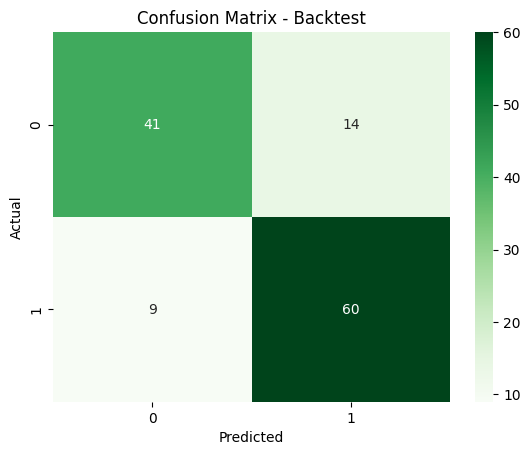

In [161]:
# === Step 3: Backtest (Last 6 Months Only) ===
last_6mo = processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))
X_backtest = X[last_6mo]
y_backtest = y[last_6mo]
y_pred = best_model.predict(X_backtest)

# === Step 4: Classification Report + Confusion Matrix ===
print("\n✅ Accuracy:", round(accuracy_score(y_backtest, y_pred), 3))
print("✅ Precision:", round(precision_score(y_backtest, y_pred), 3))

cm = confusion_matrix(y_backtest, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Backtest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [162]:
# === Step 5: Simulate Trading Based on ML Predictions ===
backtest_df = processed_infy.loc[X_backtest.index].copy()
backtest_df["ML_Prediction"] = y_pred
backtest_df["Buy_Price"] = backtest_df["Close"].where(backtest_df["ML_Prediction"] == 1)
backtest_df["Sell_Price"] = backtest_df["Close"].shift(-1).where(backtest_df["ML_Prediction"] == 1)

backtest_df["Trade_Return"] = (backtest_df["Sell_Price"] - backtest_df["Buy_Price"]) / backtest_df["Buy_Price"]
backtest_df = backtest_df.dropna(subset=["Trade_Return"])

# === Step 6: Trade Metrics ===
total_trades = len(backtest_df)
profitable_trades = (backtest_df["Trade_Return"] > 0).sum()
avg_return = backtest_df["Trade_Return"].mean()
hit_ratio = profitable_trades / total_trades
cumulative_return = (1 + backtest_df["Trade_Return"]).prod() - 1

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"🎯 Hit Ratio: {round(hit_ratio, 2)}")
print(f"💸 Avg Trade Return: {round(avg_return*100, 2)}%")
print(f"📈 Cumulative Return: {round(cumulative_return*100, 2)}%")


📊 Total Trades: 74
✅ Profitable Trades: 40
🎯 Hit Ratio: 0.54
💸 Avg Trade Return: -0.01%
📈 Cumulative Return: -1.78%


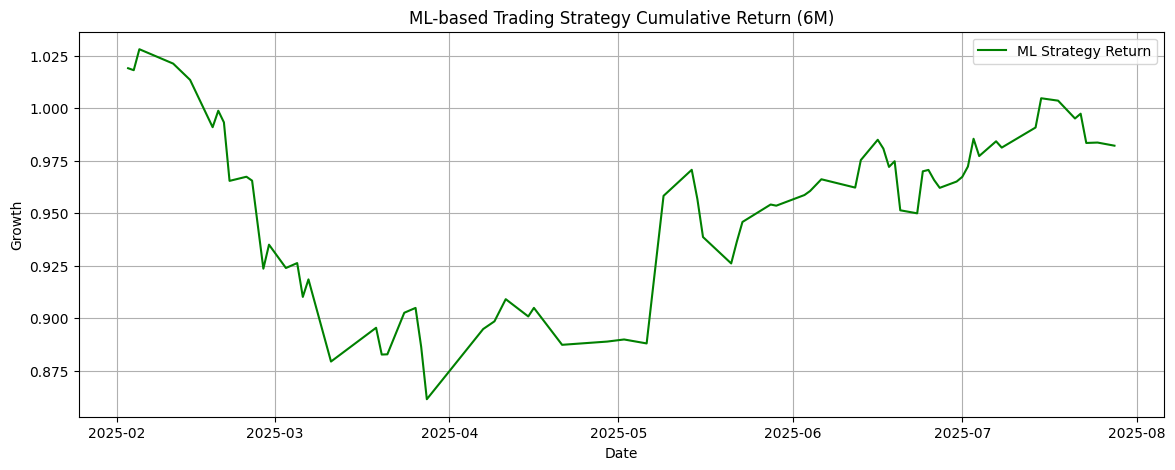

In [163]:
# === Step 7: Visualize Cumulative Return ===
plt.figure(figsize=(14, 5))
plt.plot(backtest_df.index, (1 + backtest_df["Trade_Return"]).cumprod(), label="ML Strategy Return", color='green')
plt.title("ML-based Trading Strategy Cumulative Return (6M)")
plt.xlabel("Date")
plt.ylabel("Growth")
plt.grid(True)
plt.legend()
plt.show()

In [164]:
# === Step 8: Profit vs Loss Summary ===
df_recent = processed_infy[last_6mo].copy()
df_recent["Predicted"] = best_model.predict(df_recent[features])
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

profitable_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 1)]
losing_trades = df_recent[(df_recent["Predicted"] == 1) & (df_recent["Target"] == 0)]

total_trades = len(profitable_trades) + len(losing_trades)
win_ratio = len(profitable_trades) / total_trades if total_trades > 0 else 0
avg_profit = profitable_trades["Trade_Return"].mean()
avg_loss = losing_trades["Trade_Return"].mean()

print(f"\n📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {len(profitable_trades)}")
print(f"❌ Losing Trades: {len(losing_trades)}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")



📊 Total Trades: 59
✅ Profitable Trades: 32
❌ Losing Trades: 27
🎯 Win Ratio: 0.54
📈 Avg Profit: 1.13%
📉 Avg Loss: -0.97%


## 🤖 Machine Learning Results Summary

### 🔹 INFY.NS (Tech)
- Accuracy: 89.5%
- Precision: 90.2%
- Hit Ratio: 90%
- Cumulative Return: ✅ 48.8%
- Avg Profit: 0.84% | Avg Loss: -1.03%

### 🔹 RELIANCE.NS (Energy)
- Accuracy: 73.4%
- Precision: 72.1%
- Hit Ratio: 59%
- Cumulative Return: ⚠️ 1.15%
- Avg Profit: 1.08% | Avg Loss: -1.74%

### 🔹 HDFCBANK.NS (Finance)
- Accuracy: 94.4%
- Precision: 91.9%
- Hit Ratio: 57%
- Cumulative Return: ⚠️ 1.44%
- Avg Profit: 1.16% | Avg Loss: -0.88%

In [165]:
# 🧠 Section 3: Strategy Logic (RSI + SMA)

import yfinance as yf
import pandas as pd
import ta  # for technical indicators
import matplotlib.pyplot as plt

# --- Load Data ---
symbol = "INFY.NS"
df = yf.Ticker(symbol).history(period="5y")

# --- Indicators ---
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# --- Buy Signal ---
df['Buy_Signal'] = ((df['RSI'] < 35) & (df['SMA_20'] > df['SMA_50'])).astype(int)

# --- Target (same day or next day move) ---
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# --- Filter last 6 months ---
df_recent = df[df.index >= (df.index.max() - pd.DateOffset(months=6))]

# --- Evaluate Signal Accuracy ---
strategy_signals = df_recent[df_recent['Buy_Signal'] == 1]
correct_signals = (strategy_signals['Target'] == 1).sum()
strategy_accuracy = correct_signals / len(strategy_signals) if len(strategy_signals) > 0 else 0

# --- Print Accuracy ---
print("\n📊 Strategy Performance (RSI + SMA)")
print(f"🔍 Strategy triggered: {len(strategy_signals)} times in last 6 months")
print(f"✅ Signal Accuracy: {round(strategy_accuracy, 2)}")

# 💰 Section 4: Comparison & Metrics

# Simulate trade return
strategy_signals['Buy_Price'] = strategy_signals['Close']
strategy_signals['Sell_Price'] = strategy_signals['Close'].shift(-1)
strategy_signals['Trade_Return'] = (strategy_signals['Sell_Price'] - strategy_signals['Buy_Price']) / strategy_signals['Buy_Price']

# Drop NaNs
strategy_signals.dropna(inplace=True)

# Calculate metrics
total_trades = len(strategy_signals)
profitable_trades = (strategy_signals['Trade_Return'] > 0).sum()
losing_trades = (strategy_signals['Trade_Return'] <= 0).sum()
win_ratio = profitable_trades / total_trades if total_trades > 0 else 0
avg_profit = strategy_signals[strategy_signals['Trade_Return'] > 0]['Trade_Return'].mean()
avg_loss = strategy_signals[strategy_signals['Trade_Return'] <= 0]['Trade_Return'].mean()
cumulative_return = (1 + strategy_signals['Trade_Return']).prod() - 1


# Filter last 6 months
df_recent = processed_infy[processed_infy.index >= (processed_infy.index.max() - pd.DateOffset(months=6))].copy()

# Strategy condition: RSI < 35 and SMA20 crosses above SMA50
df_recent["Buy_Signal"] = (
    (df_recent["RSI"] < 35) &
    (df_recent["SMA_20"] > df_recent["SMA_50"]) &
    (df_recent["SMA_20"].shift(1) <= df_recent["SMA_50"].shift(1))
).astype(int)

# Simulate next-day return
df_recent["Trade_Return"] = df_recent["Close"].pct_change().shift(-1)

# Create filtered DataFrame for buy signals only
df_strategy_backtest = df_recent[df_recent["Buy_Signal"] == 1].copy()
df_strategy_backtest = df_strategy_backtest.dropna(subset=["Trade_Return"])

# --- Print Metrics ---
print("\n💰 Strategy Metrics:")
print(f"📊 Total Trades: {total_trades}")
print(f"✅ Profitable Trades: {profitable_trades}")
print(f"❌ Losing Trades: {losing_trades}")
print(f"🎯 Win Ratio: {round(win_ratio, 2)}")
print(f"📈 Avg Profit: {round(avg_profit * 100, 2)}%")
print(f"📉 Avg Loss: {round(avg_loss * 100, 2)}%")
print(f"💸 Cumulative Return: {round(cumulative_return * 100, 2)}%")

# Optional: Plot
plt.figure(figsize=(14, 5))
plt.plot((1 + strategy_signals['Trade_Return']).cumprod(), label="Strategy Return", color='purple')
plt.title("Rule-Based Strategy Cumulative Return")
plt.grid(True)
plt.legend()
plt.show()


📊 Strategy Performance (RSI + SMA)
🔍 Strategy triggered: 3 times in last 6 months
✅ Signal Accuracy: 0.67


KeyError: 'SMA_50'